In [1]:
# 导入包

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

In [2]:
# 设置transforms
transform = transforms.Compose([
    transforms.ToTensor(), # numpy -> Tensor
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # 归一化，范围[-1, 1]
])

In [3]:
# 下载数据集
# 训练集
trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
# 测试集
testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 批量读取数据
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

torch.Size([128, 3, 32, 32])
torch.Size([128])


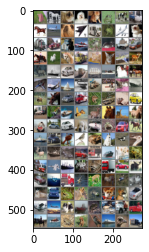

 deer horse   cat   dog   cat  frog   dog truck horse plane   dog plane truck  frog plane   cat truck truck truck  ship  bird   cat truck   car horse   dog   dog truck   cat   cat plane  deer  deer  ship   car truck  ship  ship   dog horse plane plane  ship  ship truck horse   cat  ship  deer  deer   car truck  frog   car  frog   car   car  frog  ship plane  deer horse  deer horse  ship   car   car   dog  ship  frog   car horse  ship   car  bird  bird  frog horse  bird  bird  deer  ship  frog   car truck  ship   dog  frog truck plane  ship  frog  frog truck   car  deer   car plane truck  bird  deer horse  bird   cat   dog truck  frog  deer  frog   dog   dog   car plane plane   dog  ship  frog  deer truck truck horse  ship  frog   dog  bird  ship  bird truck


In [5]:
# 可视化显示
import matplotlib.pyplot as plt
import numpy as np

# 10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
# 随机获取一批数据
imgs, labs = next(iter(train_loader))

print(imgs.shape)
print(labs.shape)

# 调用方法
imshow(torchvision.utils.make_grid(imgs))

# 输出这批图片对应的标签
print(' '.join('%5s' % classes[labs[i]] for i in range(BATCH_SIZE)))

In [6]:
# 定义网络模型

import torch.nn as nn
import torch.nn.functional as F

"""
知识点：
1. 特征图尺寸的计算公式为：[(原图片尺寸 — 卷积核尺寸) / 步长 ] + 1
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1， 输入是32*32*3，计算（32-5）/ 1 + 1 = 28，那么通过conv1输出的结果是28*28*6
        self.conv1 = nn.Conv2d(3, 6, 5) # input:3, output:6, kernel:5
        # 池化层，  输入是28*28*6，窗口2*2，计算28 / 2 = 14，那么通过max_pool1层输出结果是14*14*6
        self.pool = nn.MaxPool2d(2, 2) # kernel:2, stride:2
        # 卷积层2， 输入是14*14*6，计算（14 - 5）/ 1 + 1 = 10，那么通过conv2输出的结果是10*10*16
        self.conv2 = nn.Conv2d(6, 16, 5) # input:6, output:16, kernel:5
        # 全连接层1
        self.fc1 = nn.Linear(16*5*5, 120) # input:16*5*5, output:120
        # 全连接层2
        self.fc2 = nn.Linear(120, 84) # input:120, output:84
        # 全连接层3
        self.fc3 = nn.Linear(84, 10) # input:84, output:10
        
    def forward(self, x):
        # 卷积1 
        """
        32x32x3 --> 28x28x6 --> 14x14x6
        """
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积2
        """
        14x14x6 --> 10x10x16 --> 5x5x16
        """
        x = self.pool(F.relu(self.conv2(x)))
        # 改变shape
        x = x.view(-1, 16*5*5)
        # 全连接层1
        x = F.relu(self.fc1(x))
        # 全连接层2
        x = F.relu(self.fc2(x))
        # 全连接层3
        x = self.fc3(x)
        return x

In [7]:
# 创建模型
net = Net().to('cuda')

In [8]:
# 定义优化器和损失函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉式损失函数

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 优化器

In [9]:
# 定义轮数
EPOCHS = 200

for epoch in range(EPOCHS):
    
    train_loss = 0.0
    for i, (datas, labels) in enumerate(train_loader):
        datas, labels = datas.to('cuda'), labels.to('cuda')
        # 梯度置零
        optimizer.zero_grad()
        # 训练
        outputs = net(datas)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()
    # 打印信息
    print("Epoch :%d , Batch : %5d , Loss : %.3f"%(epoch+1, i+1, train_loss/len(train_loader.dataset)))

Epoch :1 , Batch :   391 , Loss : 0.018
Epoch :2 , Batch :   391 , Loss : 0.018
Epoch :3 , Batch :   391 , Loss : 0.018
Epoch :4 , Batch :   391 , Loss : 0.017
Epoch :5 , Batch :   391 , Loss : 0.017
Epoch :6 , Batch :   391 , Loss : 0.016
Epoch :7 , Batch :   391 , Loss : 0.015
Epoch :8 , Batch :   391 , Loss : 0.015
Epoch :9 , Batch :   391 , Loss : 0.014
Epoch :10 , Batch :   391 , Loss : 0.013
Epoch :11 , Batch :   391 , Loss : 0.013
Epoch :12 , Batch :   391 , Loss : 0.012
Epoch :13 , Batch :   391 , Loss : 0.012
Epoch :14 , Batch :   391 , Loss : 0.012
Epoch :15 , Batch :   391 , Loss : 0.011
Epoch :16 , Batch :   391 , Loss : 0.011
Epoch :17 , Batch :   391 , Loss : 0.011
Epoch :18 , Batch :   391 , Loss : 0.011
Epoch :19 , Batch :   391 , Loss : 0.011
Epoch :20 , Batch :   391 , Loss : 0.010
Epoch :21 , Batch :   391 , Loss : 0.010
Epoch :22 , Batch :   391 , Loss : 0.010
Epoch :23 , Batch :   391 , Loss : 0.010
Epoch :24 , Batch :   391 , Loss : 0.010
Epoch :25 , Batch :   391

Epoch :199 , Batch :   391 , Loss : 0.001
Epoch :200 , Batch :   391 , Loss : 0.001


In [10]:
# 保存模型
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

In [11]:
# 加载模型

model = Net()

model.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

In [12]:
# 测试
correct = 0
total = 0
with torch.no_grad():
    for i , (datas, labels) in enumerate(test_loader):
        # 输出
        outputs = model(datas) # outputs.data.shape --> torch.Size([128, 10])
        _, predicted = torch.max(outputs.data, dim=1) # 第一个是值的张量，第二个是序号的张量
        # 累计数据量
        total += labels.size(0)  # labels.size() --> torch.Size([128]) , labels.size(0) --> 128
        # 比较有多少个预测正确
        correct += (predicted == labels).sum() # 相同为1，不同为0，利用sum()求总和
    print("在10000张测试集图片上的准确率：{:.3f}%".format(correct / total * 100))

在10000张测试集图片上的准确率：61.620%


In [13]:
# 显示每一类预测的概率

class_correct = list(0. for i in range(10))
total = list(0. for i in range(10))

with torch.no_grad():
    for (images, labels) in test_loader:
        outputs = model(images) # 输出
        _, predicted = torch.max(outputs, dim=1) # 获取到每一行最大值的索引
        c = (predicted == labels).squeeze() # squeeze() 去掉0维【默认】， unsqueeze() 增加一维
        if labels.shape[0] == 128:
            for i in range(BATCH_SIZE):
                label = labels[i] # 获取每一个label
                class_correct[label] += c[i].item() # 累计为True的个数, 注意：1 + True = 2, 1 + False = 1
                total[label] += 1 # 该类总的个数
            
# 输出正确率
for i in range(10):
    print("正确率 ： %5s : %2d %%" % (classes[i], 100 * class_correct[i] / total[i]))

正确率 ： plane : 61 %
正确率 ：   car : 76 %
正确率 ：  bird : 53 %
正确率 ：   cat : 38 %
正确率 ：  deer : 53 %
正确率 ：   dog : 54 %
正确率 ：  frog : 69 %
正确率 ： horse : 64 %
正确率 ：  ship : 74 %
正确率 ： truck : 70 %
